# Inferring a mean and standard deviation

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np
import bayesflow as bf

INFO:bayesflow:Using backend 'jax'

Here we will estimate the mean and standard deviation, assuming data
following a Gaussian distribution. The model can be summarised as

Note that contrary to the JAGS/BUGS implementation, we can specify the
model with whatever parametrization we want, and so we can use the
standard deviation parameter ($\sigma$) directly in the model.

We want to produce a network that can handle data of various sample
sizes $n$. The inference net expects an input of the same size, and so
we need a way how to summarise the raw data into a vector of a fixed
length.

We could simply exploit the fact that Gaussian data
$\textbf{x} = (x_1, \dots, x_n)$ can be sufficiently described by its
observed mean $\bar{x} = \sum_i^n \frac{x_i}{n}$, standard deviation
$s = \sqrt{\frac{\sum_i^n (x_i - \bar{x})^2}{n-1}}$, and sample size
$n$. You may notice that this is also the approach that we used in the
previous chapters where we summarised a vector of bernoulli trials
$\textbf{x}$ in terms of its sufficient statistics: number of successes
$k$ and the number of trials $n$.

### Simulator

In [2]:
def context(batch_size):
    n = np.random.randint(10, 501, size=batch_size)
    return dict(n = n)

def prior():
    mu = np.random.normal()
    sigma = np.random.gamma(shape=2, scale=1)
    return dict(mu=mu, sigma=sigma)

def summary(y):
    mean = np.mean(y)
    sd = np.std(y)
    return dict(mean=mean, sd=sd)
    
def likelihood(n, mu, sigma):
    y = np.random.normal(loc=mu, scale=sigma, size=n)
    return summary(y)


simulator = bf.simulators.make_simulator([prior, likelihood], meta_fn=context)

df = simulator.sample(100)

for key, value in df.items():
    print(key, "\tshape:", np.array(value).shape)

n   shape: (100, 1)
mu  shape: (100, 1)
sigma   shape: (100, 1)
mean    shape: (100, 1)
sd  shape: (100, 1)

### Approximator

In [ ]:
adapter=(
    bf.Adapter()
    .broadcast("n", to="mean")
    .constrain(["sigma", "sd"], lower=0)
    .standardize()
    .concatenate(["mu", "sigma"], into="inference_variables")
    .concatenate(["n", "mean", "sd"], into="inference_conditions")
    )

In [4]:
workflow=bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow()
)

### Training

In [ ]:
history = workflow.fit_online(epochs=20, batch_size=512)

### Validation

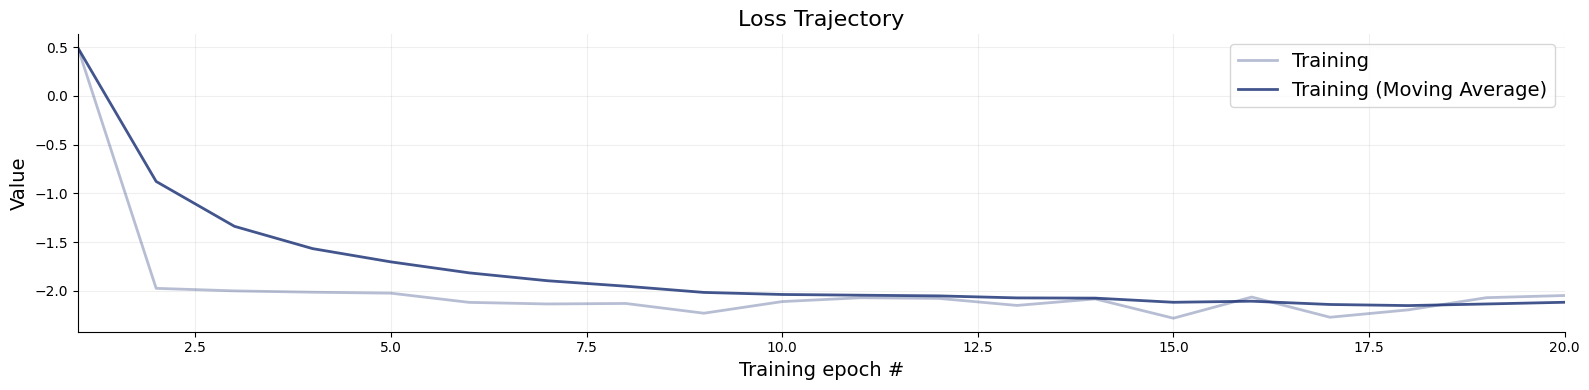

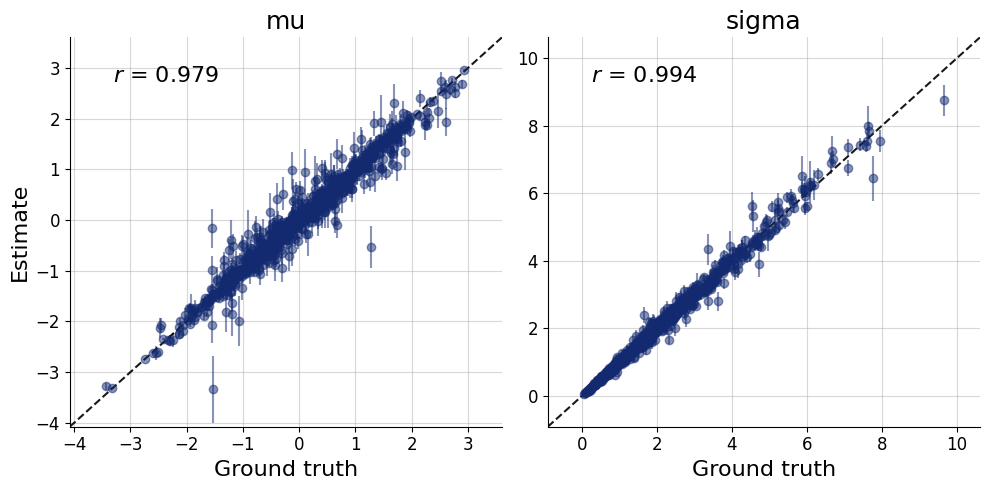

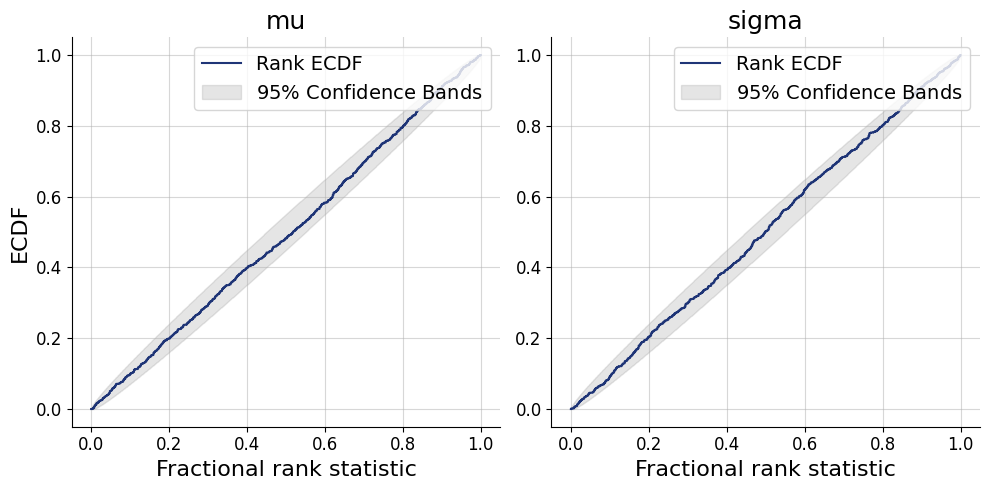

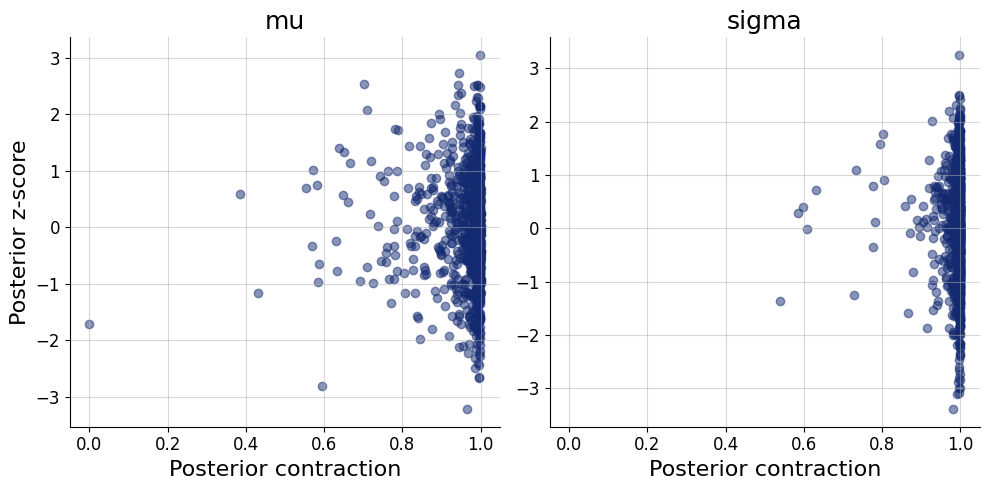

In [6]:
test_data=simulator.sample(1000)
figs=workflow.plot_default_diagnostics(test_data=test_data, num_samples=500)

### Inference

In [9]:
y=np.array([1.1, 1.9, 2.3, 1.8])
df=summary(y)
df["n"]=y.shape[0]

inference_data={key: np.array(df[key]).reshape(1, 1) for key in df.keys()}

In [10]:
samples=workflow.sample(num_samples=2000, conditions=inference_data)

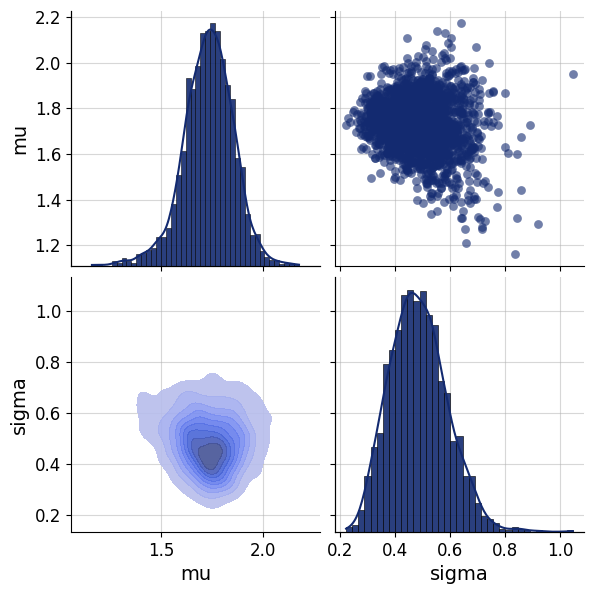

In [11]:
f=bf.diagnostics.plots.pairs_posterior(samples)